# 신경망 모델 훈련

### 케라스 API를 사용해 모델 훈련에 필요한 도구를 알아본다.

## 1. 손실곡선

In [1]:
# 데이터셋 불러오기
from tensorflow import keras
from sklearn.model_selection import train_test_split

# 훈련데이터 테스트 데이터 
(train_input, train_target), (test_input, test_target) = \
        keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [4]:
# 딥러닝 모델을 만드는 간단한 함수 정의 
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:
        model.add(keras.layers.Dense(10, activation='softmax'))
    return model

### 층을 추가하지 않고 단순히 model_fn() 호출

In [5]:
model = model_fn()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        78,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,500 (306.64 KB)

 Trainable params: 78,500 (306.64 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
#### 모델 설정 및 훈련, 훈련결과를 변수에 담는다.
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=5, verbose=0) # verbose : 훈련과정 출력 조절, 0 - 훈련과정을 나타내지 않음.

In [7]:
# history 딕셔너리 확인
print(history.history.keys())

dict_keys(['accuracy', 'loss'])


#### 손실도와 정확도 그래프 그리기

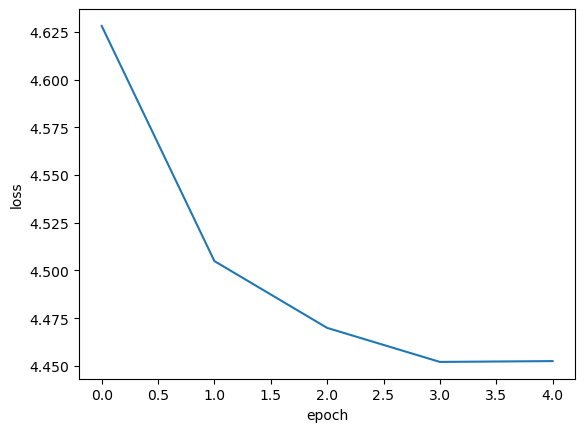

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

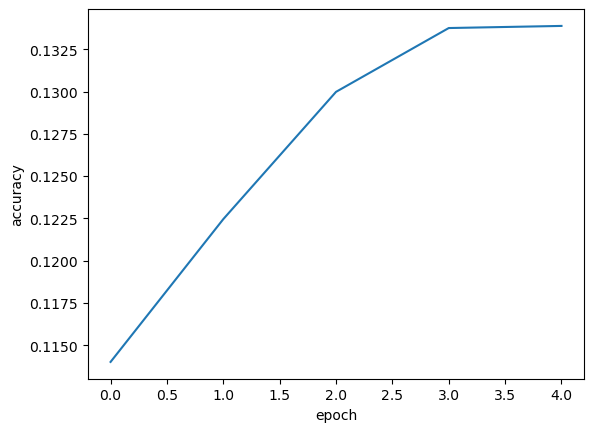

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

### 에포크마다 손실이 감소하고 정확도가 향상되고 있음

In [10]:
#### 에포크 수를 늘려 모델을 훈련하고 손실, 정확도 그래프를 그린다.
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0) # verbose : 훈련과정 출력 조절, 0 - 훈련과정을 나타내지 않음.

C:\Users\602-01\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


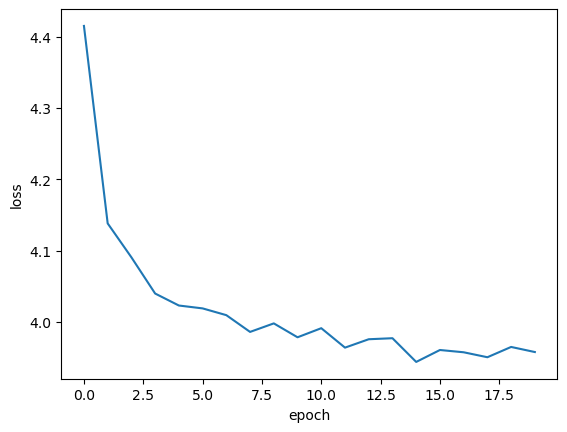

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

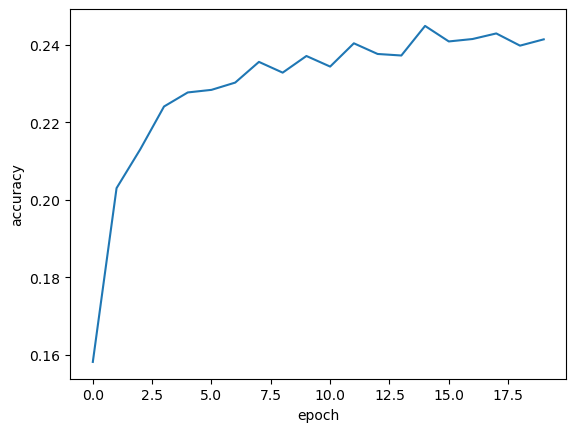

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

#### 예상대로 손실이 잘 감소함.

## 2. 검증 손실 

#### 과대적합, 과소적합을 파악하기 위해 훈련세트, 검증세트에 대한 점수

In [17]:
# 에포크마다 검증손실을 계산하기 위해 케라스 모델에 검증 데이터를 전달
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

In [18]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


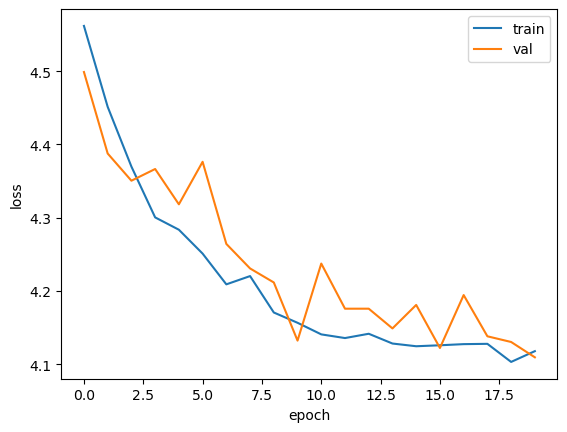

In [19]:
# 훈련손실과 검증 손실을 그래프로 비교

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

#### 훈련 손실은 꾸준히 감소하기 때문에 과대적합 모델이 만들어짐
#### 검증손실이 증가하는 시점을 뒤로 늦추면 검증세트의 손실이 줄어들고 정확도도 늘어날것임.
#### 옵티마이저 하이퍼 파라미터를 조정하여 과대적합을 완화시킨다.

In [20]:
# Adam 옵티마이저 적용
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

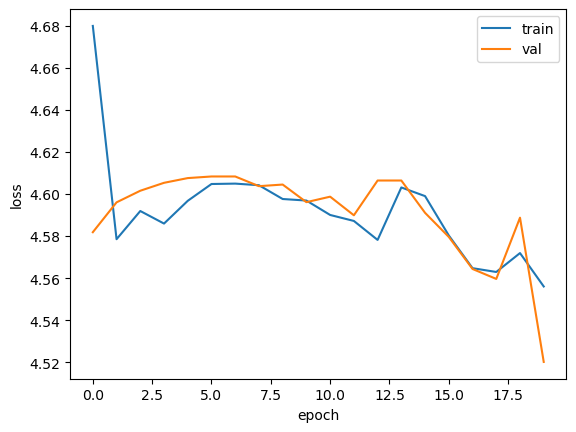

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

#### 옵티마이저 적용으로 과대적합이 훨씬 줄었음. 10번째 에포크 까지 전반적으로 감소 추세임.

## 3. 드롭 아웃

#### 드롭아웃 - 학습 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서 과대적합을 막는 기법

#### 특정 뉴런에 과도하게 의존하는 것을 줄일 수 있다. -> 안정적인 예측을 만들 수 있음.
#### 케라스 드롭아웃 클래스 : keras.layers.Dropout

In [22]:
model = model_fn(keras.layers.Dropout(0.3)) # 30%를 드롭아웃으로 지정
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

#### 은닉층에 추가된 드롭아웃 층은 훈련되는 모델 파라미터가 없다.
#### 입력과 출력 크기가 같다.

In [23]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

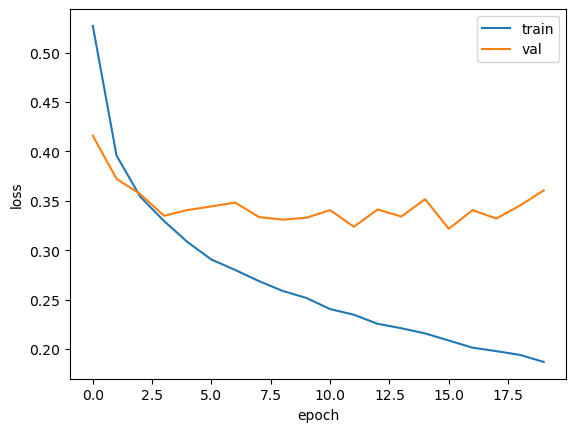

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

#### 과대적합이 확실히 줄어들었고, 10번쨰 에포크 정도에서 검증손실이 상승하지 않고 유지되고있음
#### <span style = 'color:red'> 과대적합되지 않은 모델을 얻기 위해 에포크 횟수를 10으로하고 다시 훈련하는 것이 좋겠음.

## 4. 모델 저장과 복원

In [26]:
# 에포크 횟수를 10으로 지정하고 다시 모델 훈련
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_scaled, train_target, epochs=10, verbose=0, validation_data=(val_scaled, val_target))

#### 케라스 모델의 훈련 파라미터를 저장하는 메소트 : save_weights()
#### HDF5 포맷으로 저장(Hierarchical Data Format) - 과학계에서 사용되는 계층적 파일 형식

In [27]:
model.save_weights('model-weights.weights.h5')

#### 모델의 구조왐 델 파라미터를 함꼐 저장하는 메소드 : save()

In [29]:
model.save('model-whole.keras')

### (1) 저장된 파일을 가지고 두가지 방식 실험.

#### 1) 저장한 모델 파라미터를 읽어서 사용하는 방법

In [30]:
# 새로운 모델을 만들고 이전에 저장했던 모델 파라미터를 적용
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.weights.h5')

### 검증 정확도 확인

#### 케라스 예측을 수행하는 메소드 : predict()
#### 머신러닝의 predict()와 달리 10개 클래스에 대한 확률을 반환.
#### 12,000 검증세트에 대한 예측 데이터는 (12000, 10) 크기의 배열을 반환함.

In [33]:
# 10개의 확률 중, 가장 큰 값의 인덱스를 골라서 타깃레이블과 비교하여 정확도 계산
import numpy as np
val_labels = np.argmax(model.predict(val_scaled), axis=-1) # 배열의 마지막 차원을 가지고 최대값 선택
print(np.mean(val_labels == val_target)) # 각 위치의 값과 타겟값이 같으면 1이고, 다르면 0. 이것을 평균하여 정확도 계산

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
0.8825


#### 2) 모델 전체 파일을 읽어서 검증세트 정확도 출력

In [35]:
model = keras.models.load_model('model-whole.keras')
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8830 - loss: 0.3408


[0.3371046781539917, 0.8824999928474426]

#### 같은 모델을 저장하고, 파일을 다시 불러서 확인한 결과 동일한 정확도를 얻었음.

## 5. 콜백

#### 콜백 - 훈련 과정에서 중간에 어떤 작업을 수행할 수 있게 해주는 객체
#### 케라스에서 Keras.callbacks 패키지 아래에 클래스가 정의됨.

In [37]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# save_best_only=True(가장 높은 점수를 만드는 모델을 저장)
checkpoint_cb = keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)

model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb])

#### 모델이 훈련한 다음 'best-bodel.keras'에 최상의 점수를 낸 모델이 저장됨.

### 앞의 베스트 모델을 읽어 예측 수행

In [39]:
model = keras.models.load_model('best_model.keras')
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8879 - loss: 0.3094


[0.31078532338142395, 0.8865000009536743]

## 6. 조기 종료

#### 검증점수가 상승하기 시작하면 과대 적합이 더 커지므로 더이상 훈련을 계속 할 필요없음.
#### 과대적합이 되기전에 훈련을 미리 중지하는 것을 조기 종료(Early Stopping)라 한다.

In [43]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# save_best_only=True(가장 높은 점수를 만드는 모델을 저장)
checkpoint_cb = keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
# restore_best_weights : 최상의 가중치 값으로 다시 복원해 줌.
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb, early_stopping_cb])

In [44]:
print(early_stopping_cb.stopped_epoch) # 중지된 반복 횟수

10


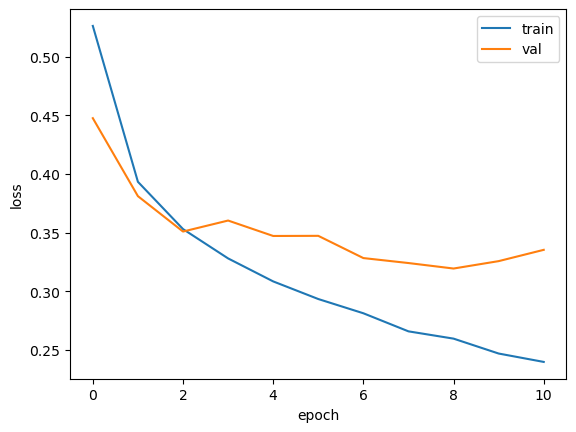

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

#### 아홉번쨰 에포크에서 가장 낮은 손실을 기록함.
#### 조기종료 기법을 사용하면 안심하고 에포크 횟수를 크게 지정해도 괜찮다.
#### ModelCheckpoint 콜백을 함께 사용하여 최상의 모델을 자동으로 지정해 줌.

In [46]:
# 조기종료 모델의 검증 세트 확인
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8889 - loss: 0.3219


[0.3194673955440521, 0.8850833177566528]